import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
# ^^^ pyforest auto-imports - don't write above this line
The goal of this notebook is to **explore the possibility of using Google's GTFS Data to find out how many trains are operating in the NYC Subway at any given time**.

More info about [GTFS Data](https://gtfs.org) in general. There are two types: 
- schedule data 
- real time data [extra information about this](https://doodles.patrickweaver.net/working-with-nyc-mta-realtime-subway-data/slides/4/)

I don't notice any difference between the two. I'll just use schedule data

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

[The project](https://tyleragreen.com/maps/new_york/) that inspired this one. [General Subway trivia](https://www.nycsubway.org/wiki/Main_Page)

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [208]:
import pandas as pd
import numpy as np
import geopandas
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings(action='once')

## Functions 

In [341]:
def determine_train_time_intervals(arrival_time, day_of_week: str):
    arrival_time = arrival_time.time()
    train_time_interval = None
    if datetime.time(0, 0) <= arrival_time < datetime.time(6, 30):
        train_time_interval = 'Late Night'
    elif day_of_week in ['Saturday', 'Sunday']:
        train_time_interval = 'Weekend'
    elif datetime.time(6, 30) <= arrival_time < datetime.time(9, 30):
        train_time_interval = 'Rush Hour AM'
    elif datetime.time(9, 30) <= arrival_time < datetime.time(15, 30):
        train_time_interval = 'Midday'
    elif datetime.time(15, 30) <= arrival_time < datetime.time(20, 0):
        train_time_interval = 'Rush Hour PM'
    elif datetime.time(20, 0) <= arrival_time <= datetime.time(23, 59):
        train_time_interval = 'Evening'
    return train_time_interval

def scale_time_intervals_to_hour(df_grouped_at_interval_level: pd.DataFrame):
    for idx, row in df_grouped_at_interval_level.iterrows():
        if row['train_time_interval'] == 'Late Night':
            new_tph = (row['trains_per_hour'] / 3) / 6.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Weekend':
            new_tph = (row['trains_per_hour'] / 2) / 17.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Rush Hour AM':
            new_tph = row['trains_per_hour'] / 3 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Midday':
            new_tph = row['trains_per_hour'] / 6 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Rush Hour PM':
            new_tph = row['trains_per_hour'] / 4.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Evening':
            new_tph = row['trains_per_hour'] / 4 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
    return df_grouped_at_interval_level

# Real Time Data

In [3]:
trips_supplemented_df = pd.read_csv("google_transit_supplemented/trips.txt")
trips_supplemented_df.head()

## Schedule Data

In [128]:
# holdays and other days when the data would be different than expected
calendar_dates_df = pd.read_csv("google_transit/calendar_dates.txt") 
calendar_df = pd.read_csv("google_transit/calendar.txt")
routes_df = pd.read_csv("google_transit/routes.txt")
stop_times_df = pd.read_csv("google_transit/stop_times.txt")
stops_df = pd.read_csv("google_transit/stops.txt")
transfers_df = pd.read_csv("google_transit/transfers.txt")
trips_df = pd.read_csv("google_transit/trips.txt")
# not useful data 
# agency_df = pd.read_csv("google_transit/agency.txt")
shapes_df = pd.read_csv("google_transit/shapes.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
all_dfs_list = [calendar_dates_df, calendar_df, routes_df, shapes_df
               , stop_times_df, stops_df, transfers_df, trips_df]

## Frequency Data 
(that I made)

In [142]:
first_stop_in_trip = pd.read_csv("first_stop_in_trip.csv", index_col=0)
route_trip_freq_by_hour = pd.read_csv("route_trip_freq_by_hour.csv", index_col=0)
first_stop_in_trip_per_day = pd.read_csv("first_stop_in_trip_per_day.csv", index_col=0)
route_trip_freq_overall_by_day = pd.read_csv("route_trip_freq_overall_by_day.csv", index_col=0).reset_index()
first_stop_in_trip_per_interval = pd.read_csv("first_stop_in_trip_per_interval.csv", index_col=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Adjustments to the GTFS Dfs

## Date Format

In [125]:
# calendar_dates_df['date'].astype('datetime')
# calendar_dates_df['date'] = pd.to_datetime(calendar_dates_df['date'], format="%Y%m%d")

In [126]:
# calendar_df['start_date'] = pd.to_datetime(calendar_df['start_date'], format="%Y%m%d")
# calendar_df['end_date'] = pd.to_datetime(calendar_df['end_date'], format="%Y%m%d")

In [129]:
stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format="%H:%M:%S"
                                                  , errors='coerce')
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format="%H:%M:%S"
                                                    , errors='coerce')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Removing Some of the data

In [130]:
# removing lat lon data
# shapes_df.drop(columns=['shape_pt_lat', 'shape_pt_lon'], inplace=True)
stops_df.drop(columns=['stop_lat', 'stop_lon'], inplace=True)
stop_times_df = stop_times_df[~stop_times_df['arrival_time'].isnull()]

# Using the Frequency Data

## Adjusting the Data

In [105]:
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
first_stop_in_trip_per_interval = first_stop_in_trip_per_interval.sort_values(by=
                                                                              ['route_id', 'train_time_interval']
                                            , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Previews of the Data

In [16]:
first_stop_in_trip.head(1)

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,departure_hour,route_id,shape_id,day_of_week,train_time_interval,direction
0,AFA23GEN-1038-Sunday-00_000600_1..S03R,101S,1900-01-01 00:06:00,1900-01-01 00:06:00,1,0.0,1,1..S03R,Sunday,Late Night,S


In [17]:
route_trip_freq_by_hour.head(1)

,day_of_week,departure_hour,trains_per_hour,headway_seconds,headway_minutes
route_id,,,,,
1,Saturday,0.0,3,1200.0,20.0


In [19]:
route_trip_freq_overall_by_day.head(1)

,Saturday,Sunday,Weekday,Weekday_Adjusted,Total_trains_per_day,Trains_per_Hour_Overall,headway_minutes
route_id,,,,,,,
1,7.75,6.416667,9.625,48.125,62.291667,8.9,6.7


In [106]:
first_stop_in_trip_per_interval.head(2)

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes
0,1,Late Night,3,1200.0,20.0
1,2,Late Night,3,1200.0,20.0


# Q & A

In [148]:
# getting the order of best performers (on weekday performance)
sorted_routes = first_stop_in_trip_per_day[first_stop_in_trip_per_day
                                 ['day_of_week']=='Weekday'].sort_values(by='trains_per_hour')['route_id'].values

## Daily Average Frequency

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

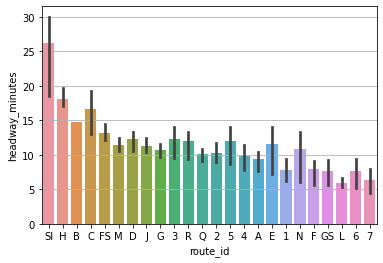

In [149]:
# with error bar 
ax = sns.barplot(data = first_stop_in_trip_per_day, x = 'route_id', y='headway_minutes', order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

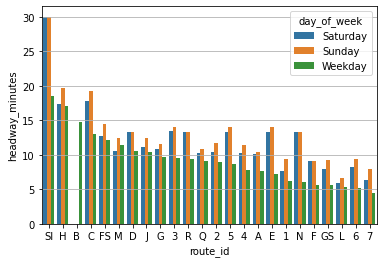

In [150]:
# separated by day 
ax = sns.barplot(data = first_stop_in_trip_per_day, x = 'route_id', y='headway_minutes'
                 , hue='day_of_week', order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

## Frequency by Interval

Late Night


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

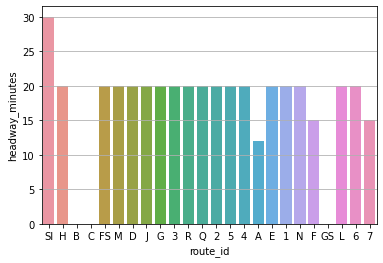

Rush Hour AM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

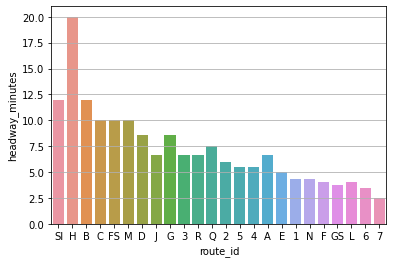

Midday


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

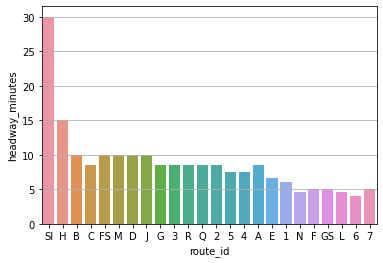

Rush Hour PM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

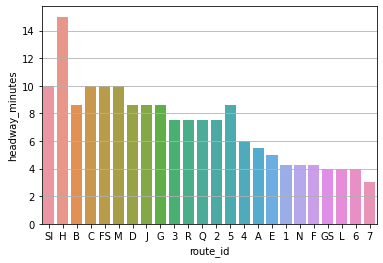

Evening


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

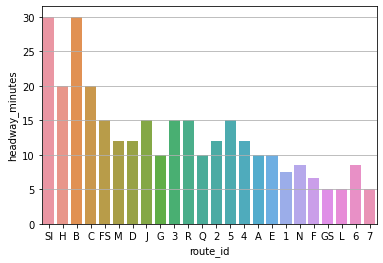

Weekend


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

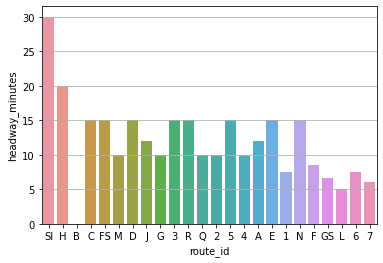

In [152]:
for interval in time_of_day_sorting.keys():
    print(interval)
    ax = sns.barplot(data = first_stop_in_trip_per_interval[first_stop_in_trip_per_interval['train_time_interval']
                                                   ==interval], x = 'route_id', y='headway_minutes', order=sorted_routes)
#     ax.title(interval)
    ax.grid(axis='y')
    plt.show()

### Best and Worst Performers by Time of Day

In [118]:
# top performers
first_stop_in_trip_per_interval.groupby(['train_time_interval', 'route_id']).sum() \
        .reset_index().sort_values(by='headway_minutes').drop_duplicates(subset='train_time_interval', keep='first')

,train_time_interval,route_id,trains_per_hour,headway_seconds,headway_minutes
78,Rush Hour AM,7,24,150.0,2.5
102,Rush Hour PM,7,20,180.0,3.0
53,Midday,6,15,240.0,4.0
6,Evening,7,12,300.0,5.0
137,Weekend,L,12,300.0,5.0
31,Late Night,A,5,720.0,12.0


In [124]:
# lowest  -- removing inf values first
# it's a tie for worst so let's just make it SIR lol 
first_stop_in_trip_per_interval[first_stop_in_trip_per_interval['headway_minutes'] < 1000].sort_values(
    by='headway_minutes').drop_duplicates(subset='train_time_interval', keep='last')

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes
88,H,Rush Hour PM,4,900.0,15.0
40,H,Rush Hour AM,3,1200.0,20.0
71,SI,Midday,2,1800.0,30.0
104,B,Evening,2,1800.0,30.0
23,SI,Late Night,2,1800.0,30.0
142,SI,Weekend,2,1800.0,30.0


### Ratios between train_time_intervals for each route

In [ ]:
# maybe start with best to worst?

# Saving the Transformed Data